In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import ezodf
import numpy as np
import seaborn as sns
import scipy.optimize as sco

In [2]:
doc = ezodf.opendoc('Data_input.ods')

print("Spreadsheet contains %d sheet(s)." % len(doc.sheets))
for sheet in doc.sheets:
    print("-"*40)
    print("   Sheet name : '%s'" % sheet.name)
    print("Size of Sheet : (rows=%d, cols=%d)" % (sheet.nrows(), sheet.ncols()) )

# convert the first sheet to a pandas.DataFrame
sheet = doc.sheets[0]
df_dict = {}
for i, row in enumerate(sheet.rows()):
    # row is a list of cells
    # assume the header is on the first row
    if i == 0:
        # columns as lists in a dictionary
        df_dict = {cell.value:[] for cell in row}
        # create index for the column headers
        col_index = {j:cell.value for j, cell in enumerate(row)}
        continue
    for j, cell in enumerate(row):
        # use header instead of column index
        df_dict[col_index[j]].append(cell.value)
# and convert to a DataFrame
df = pd.DataFrame(df_dict)

Spreadsheet contains 2 sheet(s).
----------------------------------------
   Sheet name : 'Sheet1'
Size of Sheet : (rows=77, cols=5)
----------------------------------------
   Sheet name : 'Sheet2'
Size of Sheet : (rows=1, cols=1)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2000-03-31 to 2018-12-31
Data columns (total 4 columns):
SPXT Index    76 non-null float64
G0O1 Index    76 non-null float64
GVQ0 Index    76 non-null float64
G2O2 Index    76 non-null float64
dtypes: float64(4)
memory usage: 3.0 KB


In [5]:
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')
df.columns.values

table=df

Text(0,0.5,'price in $')

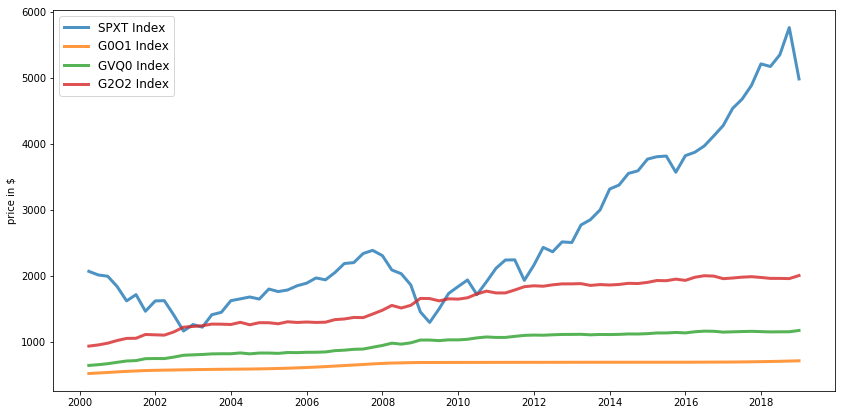

In [10]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
    
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0,0.5,'daily returns')

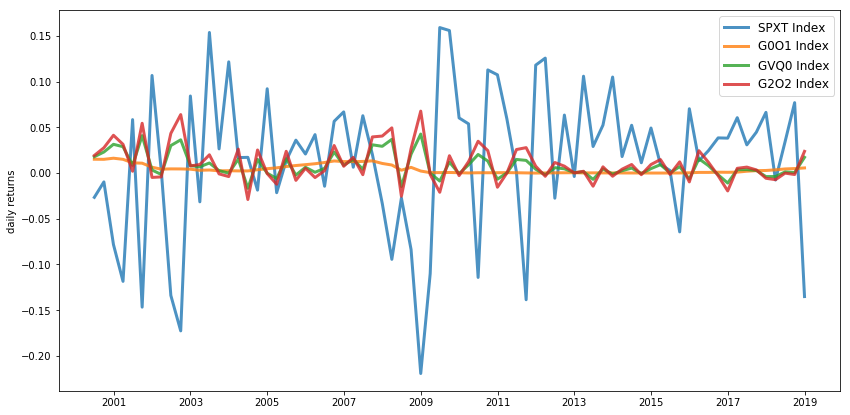

In [12]:
returns = table.pct_change()
# (P2-P1)/P1

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [13]:
# n is a number of periods in a year
# for daily data: 252
# for monthly:12

# what is mean_returns?

def portfolio_annualised_performance(weights, mean_returns, cov_matrix, n):
    returns = np.sum(mean_returns*weights )*n
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(n)
    return std, returns

In [14]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, n, n_assets):
    results = np.zeros((3,num_portfolios))
    #portfolio std, return and Sharpe
    
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(n_assets)
        # since we got 4 assets
        
        weights /= np.sum(weights)
        # normalize weights
        
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix, n)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = portfolio_return / portfolio_std_dev
    return results, weights_record

In [15]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [18]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios):
    # first, random portfolios are generated
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, n, n_assets)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    # np.argmax(results[2]) gives index of highets Sharpe
    # finds such sdp and rp that their Sharpes are max
    
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    # creates dataframe with weights of max sharpe as data 
    # Asset names as indices; 'Allocation' as column name
    
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    
    # minimum volatility is taken as optimization goal
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    # red asterisk is max Sharpe
    
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    # green asterisk is min volatility
    
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.49
Annualised Volatility: 0.08


            SPXT Index  G0O1 Index  GVQ0 Index  G2O2 Index
allocation        5.05       76.14        1.87       16.94
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 1.24
Annualised Volatility: 0.07


            SPXT Index  G0O1 Index  GVQ0 Index  G2O2 Index
allocation        2.75       89.88        2.16        5.21


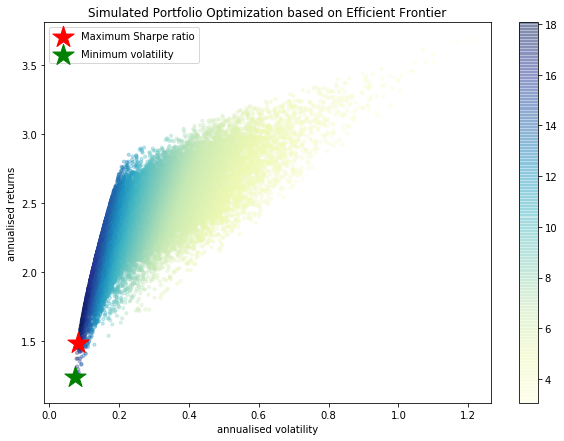

In [21]:
n=4
n_assets=4
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.02
Annualised Volatility: 0.01


            SPXT Index  G0O1 Index  GVQ0 Index  G2O2 Index
allocation        5.19       71.11       13.88        9.81
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.02
Annualised Volatility: 0.01


            SPXT Index  G0O1 Index  GVQ0 Index  G2O2 Index
allocation        1.96       91.96        0.61        5.47


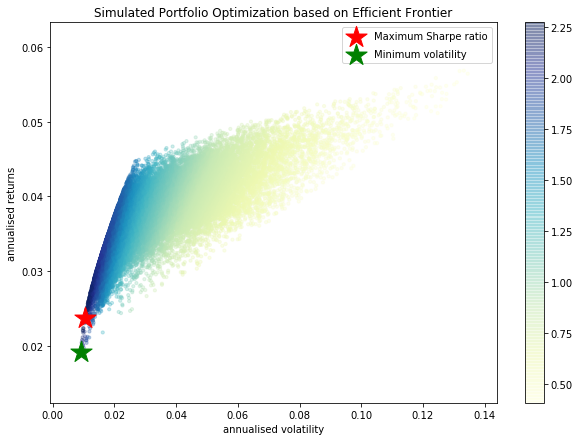

In [22]:
n=4
n_assets=4
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios)